# Heart Disease Prediction

## 1. Introduction
This project uses the UCI Heart Disease dataset to build a machine learning model for predicting heart disease. The goal is to classify whether a person has heart disease based on clinical attributes.


## Data Collection and Overview

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from ucimlrepo import fetch_ucirepo

# Fetch the dataset from UCI Machine Learning Repository
dataset = fetch_ucirepo(id=45)

# create a DataFrame from the dataset
df = dataset.data.original
target = dataset.data.targets


df['target'] = target

In [3]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2,2
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0,0


In [4]:
df.target.nunique(), df.target.unique(), df.target.value_counts()

(5,
 array([0, 2, 1, 3, 4]),
 target
 0    164
 1     55
 2     36
 3     35
 4     13
 Name: count, dtype: int64)

The dataset is of multi classification.
0 = no disease and
1, 2, 3, 4 = varying levels of disease (the higher the number, the more severe the condition)

## Data Cleaning and Preprocessing

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        299 non-null    float64
 12  thal      301 non-null    float64
 13  num       303 non-null    int64  
 14  target    303 non-null    int64  
dtypes: float64(3), int64(12)
memory usage: 35.6 KB


In [6]:
df.cp.nunique(), df.cp.unique(), df.cp.value_counts(), df.shape, df.isna().sum()

(4,
 array([1, 4, 3, 2]),
 cp
 4    144
 3     86
 2     50
 1     23
 Name: count, dtype: int64,
 (303, 15),
 age         0
 sex         0
 cp          0
 trestbps    0
 chol        0
 fbs         0
 restecg     0
 thalach     0
 exang       0
 oldpeak     0
 slope       0
 ca          4
 thal        2
 num         0
 target      0
 dtype: int64)

In [7]:
df = df.dropna()
print(df.isna().sum())

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
num         0
target      0
dtype: int64


We found missing values in the 'ca' and 'thal' columns. Since there were only a few, we dropped those rows.

Prepare out binary classification dataset.

In [8]:
# Convert target values to binary: 0 (no disease), 1 (disease present)
df['binary_target'] = df['target'].apply(lambda x: 1 if x != 0 else 0)

# Check unique values and their counts
print("Unique binary target labels:", df['binary_target'].unique())
print("Value counts:\n", df['binary_target'].value_counts())


Unique binary target labels: [0 1]
Value counts:
 binary_target
0    160
1    137
Name: count, dtype: int64


C:\Users\killjoy\AppData\Local\Temp\ipykernel_8288\3588297542.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['binary_target'] = df['target'].apply(lambda x: 1 if x != 0 else 0)


## Exploratory Data Analysis (EDA)
Visualizing target class distribution and feature correlation with the target variable.


In [9]:
# list of categorical and numerical features
cat_cols= ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']
numeric_cols = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak','ca']

In [10]:
def histogram_plot(df, col):
    plt.figure(figsize=(10, 4))
    plt.title(f"Distribution of {col}")
    sns.histplot(df[col], kde=True, bins=30, color='skyblue', edgecolor='black')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

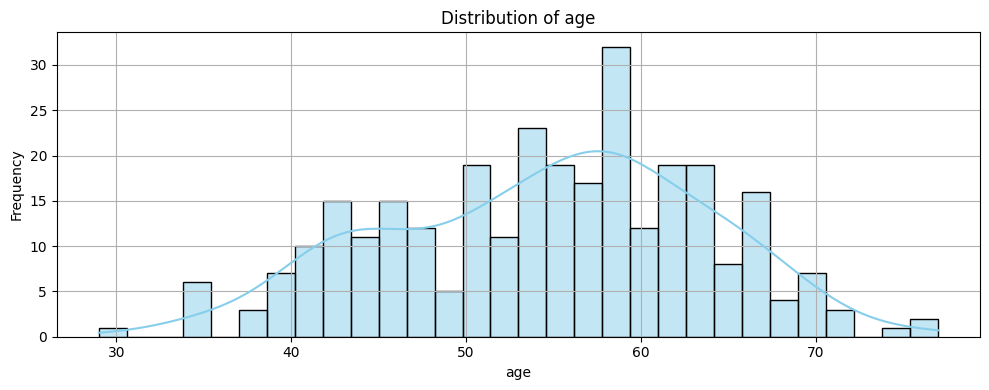

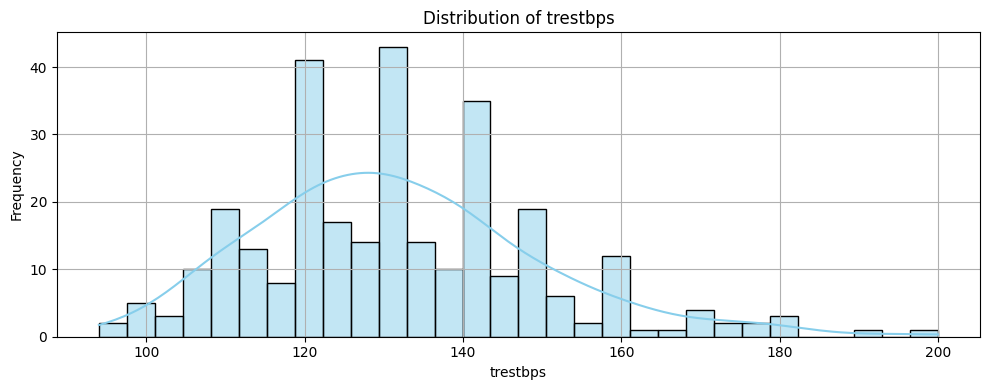

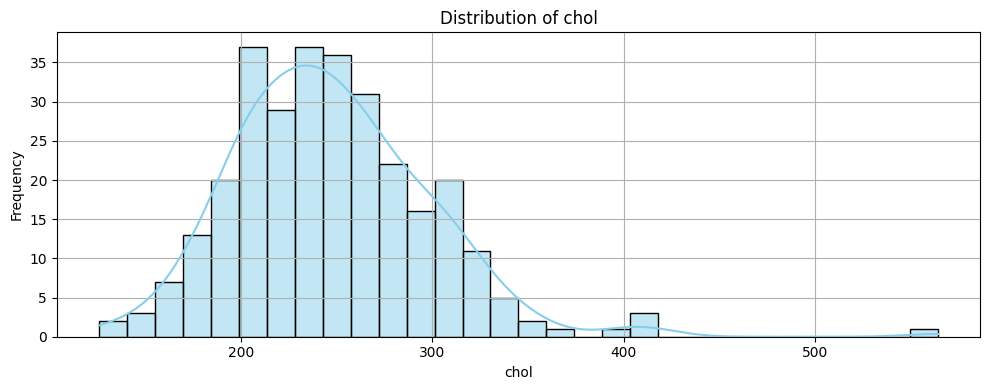

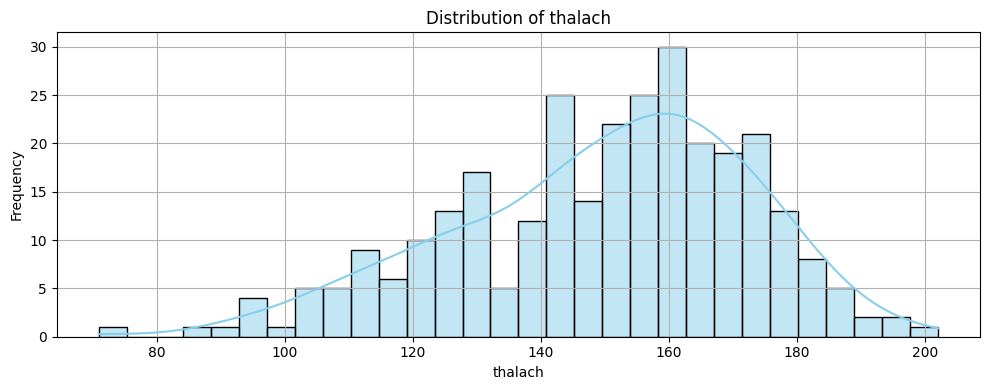

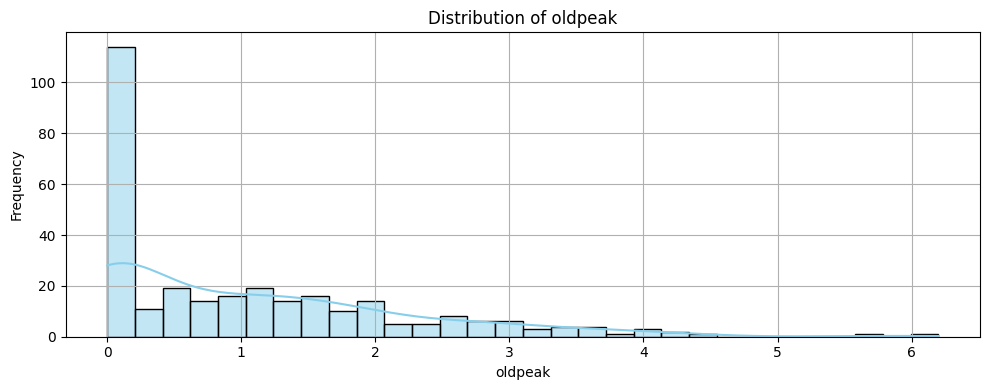

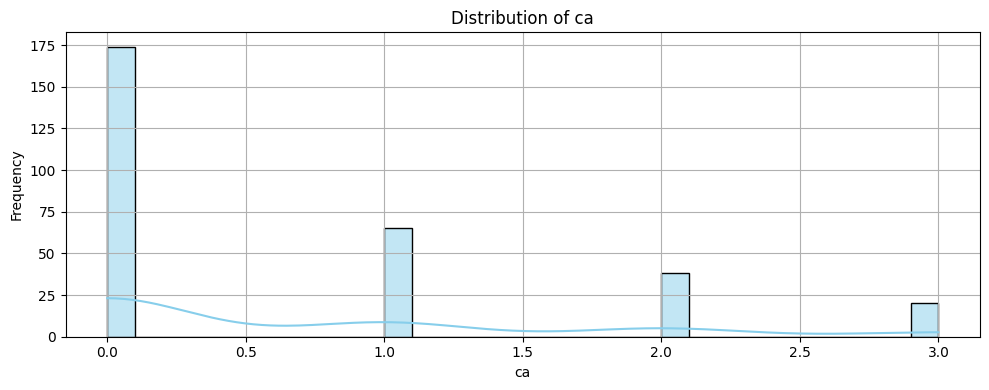

In [11]:
for col in numeric_cols:
    histogram_plot(df, col)

## Data Splitting & Scaling

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(columns=['target', 'binary_target', 'num']),
    df['binary_target'],
    test_size=0.2,
    random_state=42,
)
print("Data split into train and test sets")

scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test_scaled[numeric_cols] = scaler.transform(X_test[numeric_cols])

print("Numerical features scaled")
print(f"X_train shape: {X_train_scaled.shape[0]}, X_test shape: {X_test_scaled.shape[0]}")

Data split into train and test sets
Numerical features scaled
X_train shape: 237, X_test shape: 60


## Model Training, Model Evaluation, & Hyperparameter Tuning

Best Parameters: {'C': 1, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}
Best Score (CV Accuracy): 0.8187056737588654

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.83      0.86        36
           1       0.77      0.83      0.80        24

    accuracy                           0.83        60
   macro avg       0.83      0.83      0.83        60
weighted avg       0.84      0.83      0.83        60



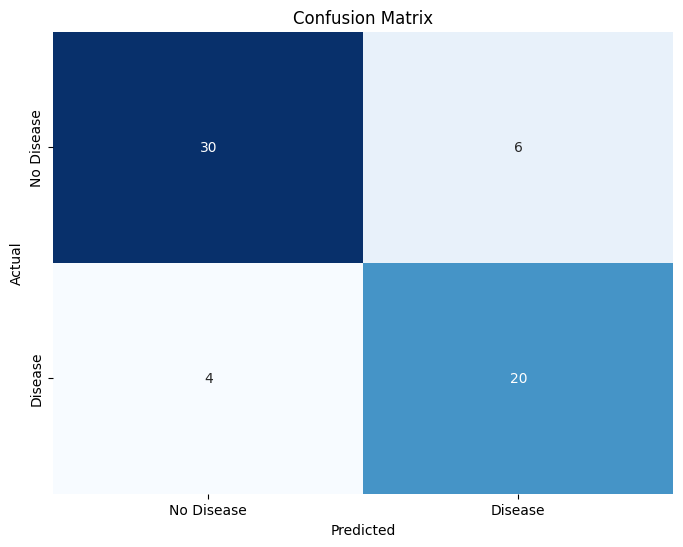

In [13]:
log_reg = LogisticRegression()

param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear'],
    'max_iter': [100, 200, 300],
}

grid_search = GridSearchCV(
    estimator=log_reg,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    n_jobs=-1,
)

grid_search.fit(X_train_scaled, y_train)

# Best results
print("Best Parameters:", grid_search.best_params_)
print("Best Score (CV Accuracy):", grid_search.best_score_)

# Evaluate on test set
y_pred = grid_search.predict(X_test_scaled)

# Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['No Disease', 'Disease'], yticklabels=['No Disease', 'Disease'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()